<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/mars_challenge/MARS_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to the MARS Challenge!**

### The [MARS challenge](https://blog.marsauto.com/introducing-the-mars-challenge-fc84c5afafbe) is a Computer Vision Task to predict vehicle speed using only camera frames.


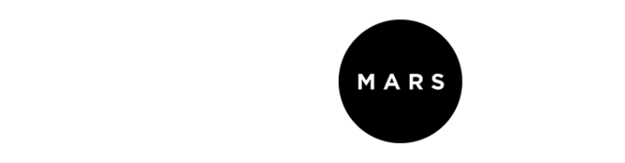

It was prepared by an automous trucking start-up called MARS as a way to identify potentially qualified candidates. The idea is to avoid a traditional whiteboard interview and instead provide a more challenging problem that requires an innate ability to solve complex problems.

<br>

### **Are you up for the challenge?** Let's get started!
This notebook will cover possible approaches to the challenge along with a survey of the training data. SUbsequent notebooks will provide more in depth approaches.

# **Challenge Background**

This challenge consists of a trianing video with accompanying ego vehicle speeds at each frame. Along with a test video with no accompanying speeds. The challenge will involve predicting the true vehicle speed of the test frames.

<br>

## **Possible Approaches**
We can approach this any number of ways that we want to, but in this series we will use threes different approaches with increasing robustness.

### **First Approach - Naive and Simple**
The first approach will involve finding the Translation and Rotation between each frame and then using those values to predict the vehicle speed. This is a two step approach. The first step will regress translation and rotation to find the best fit between two frames, the second step will be to use those values in a model that can predict the vehicle speed. This is the simplist reasonable approach I could think of, can you think of one that is more simple?

### **Second Approach - A little bit better**
The second approach will involve predicting the dense optical flow between frames and using that value to regress the speed. This method will be end-to-end with a pre-trained deep neural network ([RAFT](https://arxiv.org/abs/2003.12039)) to predict the optical flow, followed by a convolutional neural network to regress the speed. NOTE: This is really just a hopeful experiment, in this notebook we will focus mainly on the first and third approaches.

### **Third Approach - Robust**
The third approach will also be an end-to-end approach, we will use a pre-trainind optical flow model and instead of predicting the optical flow from two frames and then regressing, we will regress the speed directly from the two frames without actually predicting the optical flow. In this case we will be able to simplify our model and utilize abstract representations learned by the model. Once again, we will use [RAFT](https://arxiv.org/abs/2003.12039) for this.

<br>

## **Why don't we just use the most robust approach?**
The reason we use multiple approaches instead of the "best possible or most robust one" is twofold. Due to the nature of open ended problems, there is really a lot to learn. Using simple approaches could reveal valuable insight that can be utilized with a more robust approach later on. Second, this is an open ended problem, there isn't really a "best approach". In fact, the simplist possible solution could be the best one, but it really depends on the use case.

Now, I know what your thinking. The "simplist approach" has the most steps, while the robust and complex approach is a black box where we input two frames and output a speed. If you already know what's going on here, feel free to skip this, if not let's sort this out!

**Simple Regression**:
- Find translation and rotation vectors between 2 consecutive frames (1 line in opencv) --> No model, just a best fit regression!
- Use translation and rotation (4 dependent variables) to predict speed (Linear Regression)

**Robust Regression**:
- Modify and Finetune [RAFT](https://arxiv.org/abs/2003.12039) to predict speed based on 2 consecutive frames

<br>

In the robust approach we are taking a very complicated nerual network and training it to do something it wasn't intended to do! Further more, we need to modify the architecutre, this is not a trivial task. In deep learning, the theory is far behind the what's in practice, that means that know one really knows exactly how deep neural nets work! But not all is lost, the fundamentals of math and statistics are still here to guide us, and thankfully those don't change. We also need to consider what the model was trained on, we may want to finetune the while architecture with optical flow from different driving scenes. There is one last thing to note about deep nerual networks, data is king. This means that the more data we have, the better chance we have of training a good model. (Even if our model architecture is sub optimal!). However, in this challenge we have a small amount of data (a really small amount of data!).

In the simple approach, we are jsut going to train a model using 4 dependent variables, there's no complex architecure, pre-training/fine-tuning, or anything like that! We'll try several models, but they will all likely be simple. A simple approach is fitting for this case, since we have a small amount of data.

In [1]:
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.txt
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/test.mp4

--2023-08-14 03:04:06--  https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4
Resolving marschallenge.s3.ap-northeast-2.amazonaws.com (marschallenge.s3.ap-northeast-2.amazonaws.com)... 52.219.144.11
Connecting to marschallenge.s3.ap-northeast-2.amazonaws.com (marschallenge.s3.ap-northeast-2.amazonaws.com)|52.219.144.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450765182 (430M) [video/mp4]
Saving to: ‘train.mp4’

train.mp4           100%[===================>] 429.88M  23.6MB/s    in 36s     

2023-08-14 03:04:43 (12.0 MB/s) - ‘train.mp4’ saved [450765182/450765182]

--2023-08-14 03:04:43--  https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.txt
Resolving marschallenge.s3.ap-northeast-2.amazonaws.com (marschallenge.s3.ap-northeast-2.amazonaws.com)... 52.219.206.2
Connecting to marschallenge.s3.ap-northeast-2.amazonaws.com (marschallenge.s3.ap-northeast-2.amazonaws.com)|52.219.206.2|:443... connected.
HTTP request sent, awaiting response

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Read the training data

In [5]:
train_df = pd.read_csv('train.txt')

In [7]:
train_df.iloc[100:110]

,0.0
100,0.053
101,0.109
102,0.146
103,0.166
104,0.209
105,0.254
106,0.267
107,0.326
108,0.344
109,0.389


As you can see, all we get is a speed. In reality, there is a velocity vector that describes the velocity of the ego vehicle in the x, y, and z directions, where we can generally assume z to be 0 for simplicity. The velocity is the displacement per unit of time in a certain direction, while speed is the overall distance travelled per unit of time.

In [10]:
train_df.describe()

,0.0
count,8099.000000
mean,3.782076
std,1.893214
min,0.000000
25%,2.486500
50%,3.800000
75%,5.000000
max,8.333000


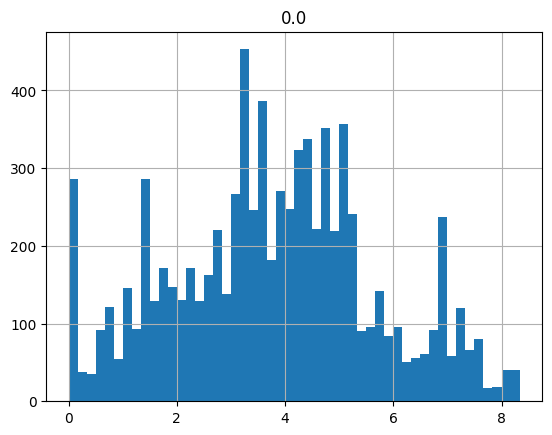

In [9]:
train_df.hist(bins=50);

# **References**

- https://blog.marsauto.com/introducing-the-mars-challenge-fc84c5afafbe
- https://www.britannica.com/story/whats-the-difference-between-speed-and-velocity